
<div align="center" style="color:#3b82f6; font-size: 40px; font-weight: bold;">

SABR MODEL

</div>

**Historical context and sources**

The SABR model (Stochastic Alpha, Beta, Rho) was introduced by Patrick S. Hagan, Deep Kumar, Andrew Lesniewski, and Diana Woodward (early 2000s). It became the standard market model for interest-rate and FX smiles because it is:

- **Parsimonious** (few parameters with clear roles),
- **Flexible** (controls skew via \( \beta \) and \( \rho \)),
- **Practical** (closed-form implied vol approximations enable fast calibration without solving PDEs).

The widely used Hagan et al. implied volatility expansions provide efficient approximations for both **Black (lognormal)** and **Normal (Bachelier)** settings and are implemented in most pricing libraries and trading systems.





In [1]:
import numpy as np
import pandas as pd
from Curve import to_years, Curve
from Model import plot_smiles, calibrate_all_tenors

Specify where the data is located.

In [ ]:
xls_path = r"YOURPATH\Datos.xlsx"

## SABR Calibration — Step by Step

### 0) Model setup and notation

We use the (shifted) **SABR** model on the forward $F$ with parameters 
$\alpha$ (vol level), $\beta$ (elasticity), $\rho$ (correlation), 
$\nu$ (vol-of-vol), maturity $T$, and optional shift $s$ applied to both 
$F$ and $K$ (to handle negative rates or ensure positivity for the lognormal case).

The SDEs under the risk-neutral measure are:

$$
dF_t = \alpha_t (F_t + s)^{\beta} \, dW_t,
$$

$$
d\alpha_t = \nu \,\alpha_t \, dZ_t,
$$

$$
d\langle W, Z \rangle_t = \rho \, dt,
$$

with constants $\beta \in [0,1]$, $\rho \in (-1,1)$, $\nu > 0$, and $\alpha_0 > 0$.

We denote shifted quantities $F' = F+s$ and $K' = K+s$. When $s=0$, we write simply $F,K$.

---

### 1) Build discount curves and forwards

#### 1.1 Log-linear DF interpolation

Given discount factor pillars $\{(t_i, P(0,t_i))\}$, interpolate in log-DF space:

$$
\ln P(0,t) \;=\; (1-w)\,\ln P(0,t_0) \;+\; w\,\ln P(0,t_1),
$$

where

$$
w = \frac{t - t_0}{t_1 - t_0}.
$$

#### 1.2 Simple forward between $t_0$ and $t_1$

With year fraction $\alpha = t_1 - t_0$ (e.g., ACT/360), the simple forward is:

$$
F_s(t_0,t_1) \;=\; \frac{P(0,t_0)/P(0,t_1) - 1}{\alpha}.
$$

---

### 2) Read and normalize the volatility matrix

The matrix is indexed by tenors $T$ (in years) and columns labelled by strikes 
(either absolute % levels or % spreads around the forward).

Market volatilities are often quoted in **basis points** of rate vol. Convert to decimals:

$$
\sigma_i^{\text{mkt}} \;=\; \frac{\text{bps}_i}{10{,}000}.
$$

---

#### 2.1 Interpreting strike columns

If strike columns contain negative values or the total range is small (e.g. $\le 10$ percentage points), 
treat them as **spreads** $c$ in percent around the forward:

$$
K = F + \frac{c}{100}.
$$

Otherwise, treat them as **absolute levels** $L$ in percent:

$$
K = \frac{L}{100}.
$$

In [ ]:
# --- Read discount factors (FD) ---
df = pd.read_excel(xls_path, sheet_name="FD", header=1)
df = df.rename(columns={"Date":"Date_ESTR","FD":"DF_ESTR","Date.1":"Date_EUR3M","FD.1":"DF_EUR3M"})
for c in ["Date_ESTR","Date_EUR3M"]:
    if c in df: df[c] = pd.to_datetime(df[c], dayfirst=True, errors="coerce")
for c in ["DF_ESTR","DF_EUR3M"]:
    if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(how="all")

estr  = df.loc[df["Date_ESTR"].notna()  & df["DF_ESTR"].notna(),  ["Date_ESTR","DF_ESTR"]].copy()
eur3m = df.loc[df["Date_EUR3M"].notna() & df["DF_EUR3M"].notna(), ["Date_EUR3M","DF_EUR3M"]].copy()
estr  = estr.sort_values("Date_ESTR").reset_index(drop=True)
eur3m = eur3m.sort_values("Date_EUR3M").reset_index(drop=True)

# Valuation date = earliest date from both curves
val_date = min(estr.loc[0,"Date_ESTR"], eur3m.loc[0,"Date_EUR3M"]).normalize()

# Time fractions in years
t_estr  = np.array([to_years(d, val_date) for d in estr["Date_ESTR"]], dtype=float)
t_eur3m = np.array([to_years(d, val_date) for d in eur3m["Date_EUR3M"]], dtype=float)

# Remove duplicates
t_estr_u,  idx_e = np.unique(t_estr,  return_index=True)
t_eur3m_u, idx_b = np.unique(t_eur3m, return_index=True)

# Build discount curves
curve_estr  = Curve.from_pillars(list(zip(t_estr_u,  estr["DF_ESTR"].to_numpy()[idx_e])))
curve_eur3m = Curve.from_pillars(list(zip(t_eur3m_u, eur3m["DF_EUR3M"].to_numpy()[idx_b])))

# --- Vols (tenors as float, strikes in %) ---
df_vols = Curve.read_volatility_matrix(xls_path, "VCUB")

### 3) Hagan’s implied volatility approximations

We use Hagan et al.’s closed-form implied volatility approximations.

Define the standard normal density:
$$
\phi(x) \;=\; \frac{1}{\sqrt{2\pi}} \exp\!\left(-\frac{x^2}{2}\right).
$$

Let shifted quantities be $F' = F + s$ and $K' = K + s$.

---

#### 3.1 Black (lognormal) SABR implied volatility

For $F' \neq K'$, define
$$
z \;=\; \frac{\nu}{\alpha} \,(F'K')^{\tfrac{1-\beta}{2}} \,\ln\!\left(\frac{F'}{K'}\right),
$$

$$
x(z) \;=\; \ln\!\left(\frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{\,1 - \rho\,}\right).
$$

Then the **Black implied volatility** is
$$

\sigma_{\mathrm{Black}}(F,K;\alpha,\beta,\rho,\nu,s,T)
= \frac{\alpha}{\big(F'K'\big)^{\tfrac{1-\beta}{2}}}\;\frac{z}{x(z)} 
\quad \times \left\{
1 \;+\;
\left[
\frac{(1-\beta)^2}{24}\,\frac{\alpha^2}{\big(F'K'\big)^{1-\beta}}
\;+\;
\frac{\rho\,\beta\,\nu\,\alpha}{4\,\big(F'K'\big)^{\tfrac{1-\beta}{2}}}
\;+\;
\frac{2 - 3\rho^2}{24}\,\nu^2
\right] T
\right\}.

$$

**ATM limit** $F' = K'$:
$$
\sigma_{\mathrm{Black,ATM}}
=
\frac{\alpha}{(F')^{1-\beta}}
\left\{
1
+
\left[
\frac{(1-\beta)^2}{24}\,\frac{\alpha^2}{(F')^{2-2\beta}}
+
\frac{\rho\,\beta\,\nu\,\alpha}{4\,(F')^{1-\beta}}
+
\frac{2 - 3\rho^2}{24}\,\nu^2
\right] T
\right\}.
$$

---

#### 3.2 Normal (Bachelier) SABR implied volatility

For $F' \neq K'$, define
$$
z \;=\; \frac{\nu}{\alpha}\,\frac{(F')^{\beta} - (K')^{\beta}}{\beta},
$$

$$
x(z) \;=\; \ln\!\left(\frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{\,1 - \rho\,}\right).
$$

Then the **Normal implied volatility** is
$$

\sigma_{\mathrm{Normal}}(F,K;\alpha,\beta,\rho,\nu,s,T)
= \alpha\,\frac{z}{x(z)} 
\quad \times \left\{
1 \;+\;
\left[
\frac{2 - 3\rho^2}{24}\,\nu^2
\;+\;
\frac{\rho\,\beta\,\nu\,\alpha}{4}\,(F')^{\beta-1}
\;+\;
\frac{(1-\beta)^2}{24}\,\alpha^2\,(F')^{2\beta-2}
\right] T
\right\}.

$$

**ATM limit** $F' = K'$:
$$
\sigma_{\mathrm{Normal,ATM}}
=
\alpha\,(F')^{\beta-1}
\left\{
1
+
\left[
\frac{2 - 3\rho^2}{24}\,\nu^2
+
\frac{\rho\,\beta\,\nu\,\alpha}{4}\,(F')^{\beta-1}
+
\frac{(1-\beta)^2}{24}\,\alpha^2\,(F')^{2\beta-2}
\right] T
\right\}.
$$

---

### 4) Vega (for weighting)

#### 4.1 Black vega (with shift)

Let
$$
d_1 \;=\; \frac{\ln\!\left(\dfrac{F'}{K'}\right) + \tfrac{1}{2}\sigma^2 T}{\sigma\sqrt{T}}.
$$

Then
$$
\mathrm{Vega}_{\mathrm{Black}} \;=\; F'\,\phi(d_1)\,\sqrt{T}.
$$

#### 4.2 Normal vega

Let
$$
d \;=\; \frac{F - K}{\sigma\sqrt{T}}.
$$

Then
$$
\mathrm{Vega}_{\mathrm{Normal}} \;=\; \sqrt{T}\,\phi(d).
$$

---

### 5) Objective function per tenor

For a given tenor $T$ with forward $F$ and strikes $\{K_i\}$ with market vols $\{\sigma^{\text{mkt}}_i\}$, and a **fixed** $\beta$, we calibrate $\theta=(\alpha,\rho,\nu)$ by solving a bounded nonlinear least-squares problem:
$$
\min_{\alpha,\rho,\nu}
\;\;
\sum_{i=1}^{n}
w_i\,
\Big(
\sigma_{\mathrm{model}}\big(F,K_i;\alpha,\beta,\rho,\nu,s,T\big)
-
\sigma^{\mathrm{mkt}}_i
\Big)^2.
$$

Weights use vega (normalized by the sample median) and an ATM boost $\lambda$ (e.g., $\lambda=10$):
$$
w_i \;=\;
\frac{\mathrm{Vega}_i}{\mathrm{median}(\mathrm{Vega})}
\;\times\;
\begin{cases}
\lambda, & \text{if } K_i \approx F,\\
1, & \text{otherwise.}
\end{cases}
$$

The residual vector (what the optimizer sees) is
$$
r_i(\alpha,\rho,\nu) \;=\;
\sqrt{w_i}\left[
\sigma_{\mathrm{model}}\big(F,K_i;\alpha,\beta,\rho,\nu,s,T\big)
-
\sigma^{\mathrm{mkt}}_i
\right],
\qquad i=1,\dots,n.
$$

The fit quality we report is the root-mean-square error
$$
\mathrm{RMSE}
=
\sqrt{\frac{1}{n}\sum_{i=1}^n
\left(
\sigma_{\mathrm{model}}(F,K_i;\hat{\alpha},\beta,\hat{\rho},\hat{\nu},s,T)
-
\sigma^{\mathrm{mkt}}_i
\right)^2 }.
$$

In practice, we solve this with a bound-constrained least-squares solver (e.g., trust region reflective), with sensible bounds:
$$
\alpha \in [10^{-8},\,5], \qquad
\rho \in [-0.999,\,0.999], \qquad
\nu \in [10^{-8},\,5].
$$

---

### 6) Initial guesses

We obtain stable starting values from the quotes.

**ATM volatility** $\sigma_{\mathrm{ATM}}^{\mathrm{mkt}}$ gives
$$
\alpha_0 \;=\; \max\!\big(10^{-8},\,\sigma_{\mathrm{ATM}}^{\mathrm{mkt}}\big)\,(F')^{\,1-\beta}.
$$

A **local skew** estimate near $K \approx F$ yields an initial $\rho_0$ (clipped), using the analytic sensitivity of the Hagan formula (heuristic in code).

Set
$$
\nu_0 \;=\; 0.5.
$$

---

### 7) Beta selection (grid search)

Fix a grid $\{\beta_j\}\subset[0.1,0.9]$. For each $\beta_j$ and each tenor, calibrate $(\alpha,\rho,\nu)$ as above and compute the RMSE.  
For that tenor keep the **best** $\beta_j$ (lowest RMSE). This produces, per tenor $T$:

- $\hat{\beta}(T)$,
- $\hat{\alpha}(T), \hat{\rho}(T), \hat{\nu}(T)$,
- fitted smile $\{\hat{\sigma}_i(T)\}$ and RMSE.

---

### 8) Converting a matrix of quotes into strikes and vols

For each tenor $T$:

1. Compute the forward from the curve:
$$
F \;=\; F_s(0,T) \;=\; \frac{P(0,0)/P(0,T) - 1}{T}.
$$

2. Extract the row of quotes (in **bps**) and convert to decimals:
$$
\sigma_i^{\mathrm{mkt}} \;=\; \frac{\text{bps}_i}{10{,}000}.
$$

3. Interpret column labels as **spreads** $c$ or **levels** $L$, and compute strikes:
$$
K_i \;=\;
\begin{cases}
F + \dfrac{c_i}{100}, & \text{(spreads)}\\[6pt]
\dfrac{L_i}{100}, & \text{(absolute levels)}.
\end{cases}
$$

4. Clean: drop non-finite entries, sort by strike, require $\ge 3$ valid points.

---

### 9) Plotting and reporting

For each tenor, on a strike grid $\{K\}$ spanning the observed strikes:

- Compute
$$
\sigma_{\mathrm{model}}\!\left(F,K;\,\hat{\alpha},\hat{\beta},\hat{\rho},\hat{\nu},s,T\right).
$$

- Scatter the market points $(K_i,\sigma^{\mathrm{mkt}}_i)$ and overlay the model curve.

- Report $\hat{\alpha}, \hat{\beta}, \hat{\rho}, \hat{\nu}, s, T$ and RMSE.


Tenor 1.0Y -> β=0.60, RMSE=6.934100e-04, mode=spreads (%)
Tenor 1.5Y -> β=0.60, RMSE=5.942429e-04, mode=spreads (%)
Tenor 2.0Y -> β=0.70, RMSE=3.805198e-04, mode=spreads (%)
Tenor 3.0Y -> β=0.80, RMSE=2.877020e-04, mode=spreads (%)
Tenor 4.0Y -> β=0.90, RMSE=2.219682e-04, mode=spreads (%)
Tenor 5.0Y -> β=0.90, RMSE=1.828817e-04, mode=spreads (%)
Tenor 6.0Y -> β=0.90, RMSE=1.530727e-04, mode=spreads (%)
Tenor 7.0Y -> β=0.90, RMSE=1.321807e-04, mode=spreads (%)
Tenor 8.0Y -> β=0.90, RMSE=1.143444e-04, mode=spreads (%)
Tenor 9.0Y -> β=0.90, RMSE=1.004998e-04, mode=spreads (%)
Tenor 10.0Y -> β=0.90, RMSE=9.052212e-05, mode=spreads (%)
Tenor 12.0Y -> β=0.90, RMSE=7.623594e-05, mode=spreads (%)
Tenor 15.0Y -> β=0.90, RMSE=6.355895e-05, mode=spreads (%)
Tenor 20.0Y -> β=0.90, RMSE=5.291827e-05, mode=spreads (%)
Tenor 25.0Y -> β=0.90, RMSE=4.793091e-05, mode=spreads (%)
Tenor 30.0Y -> β=0.90, RMSE=4.392208e-05, mode=spreads (%)


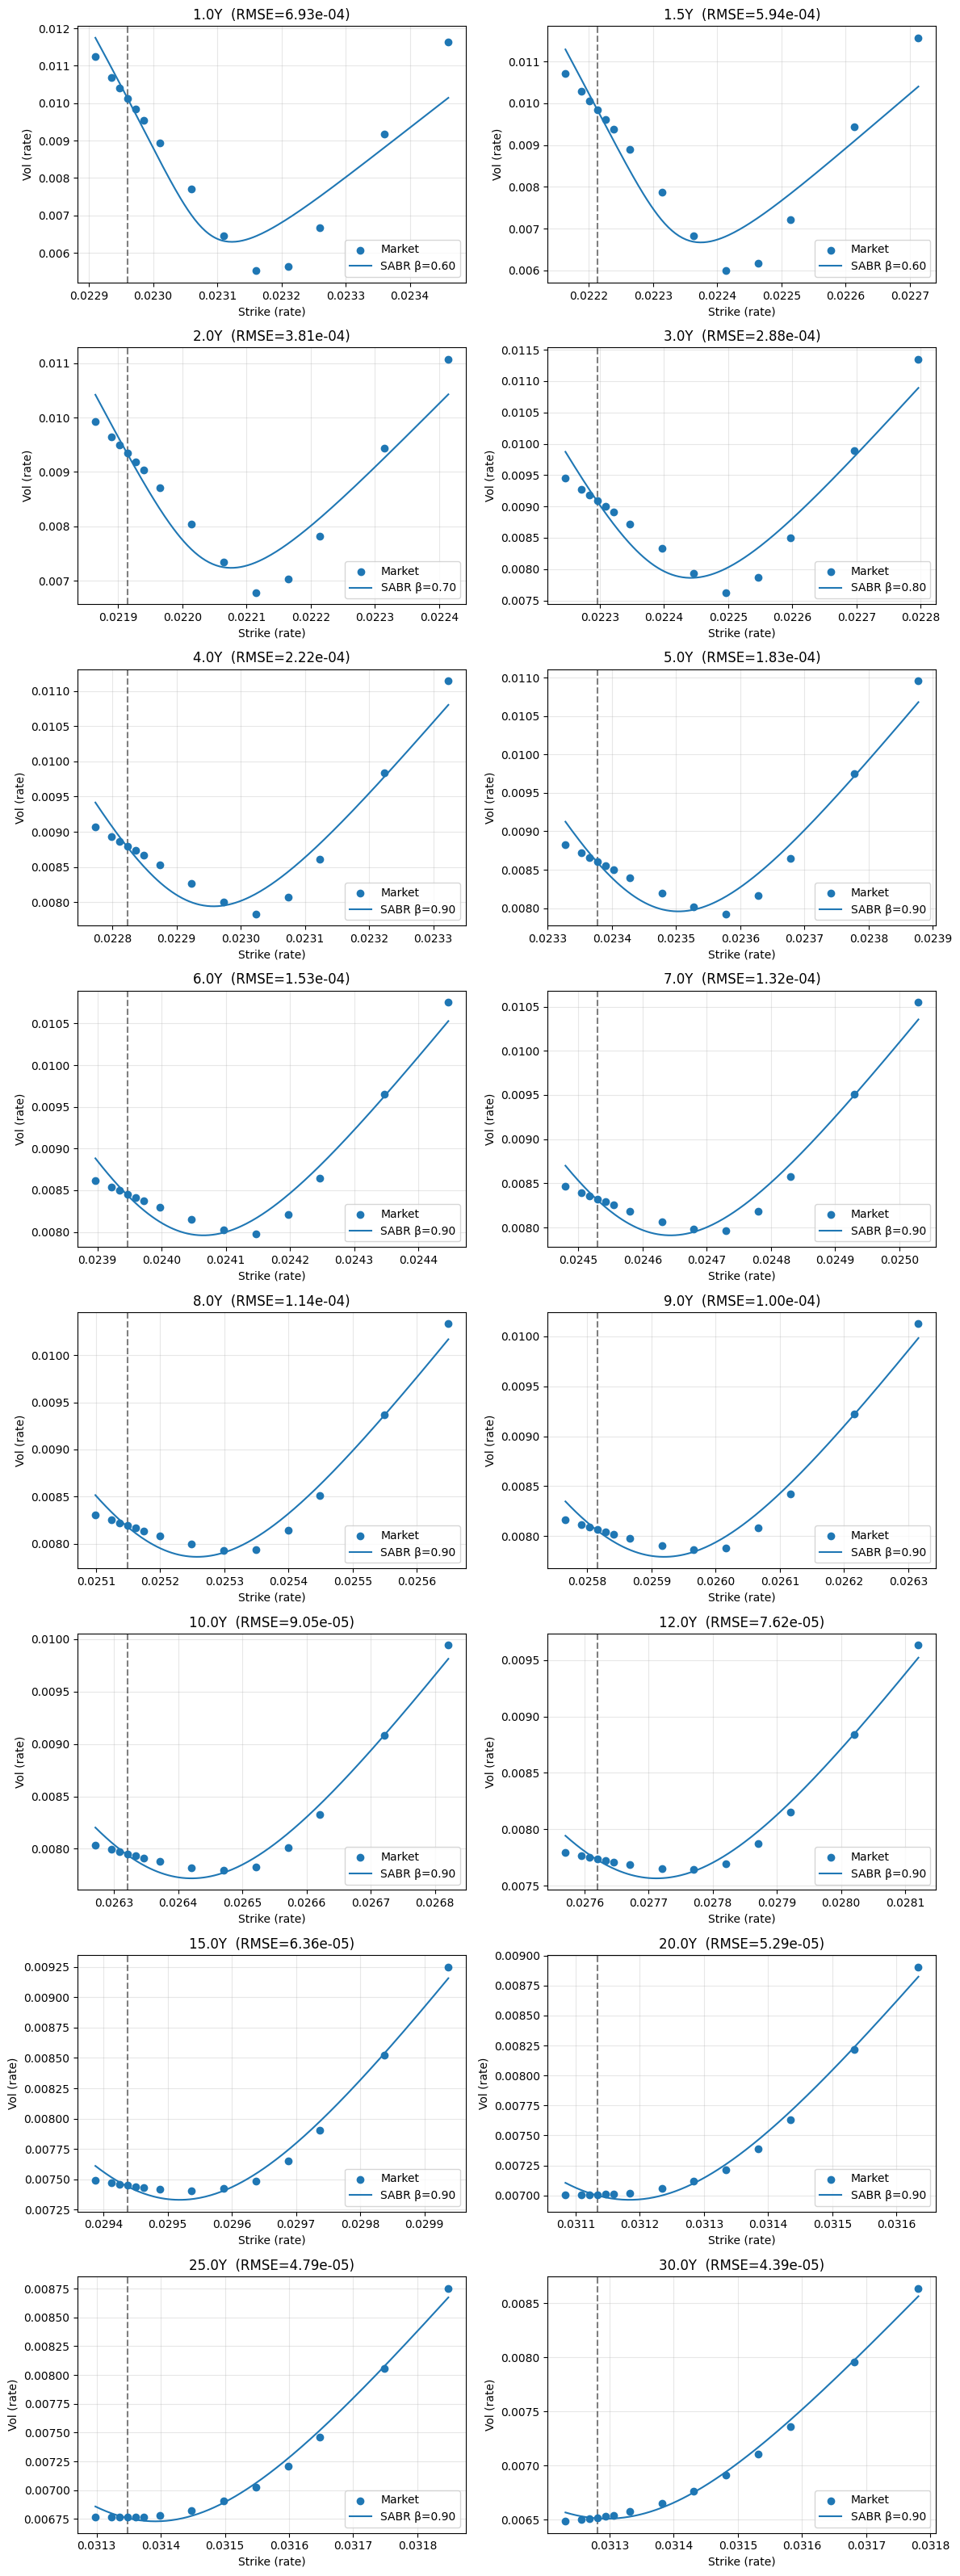


Parameters by tenor:
  TenorY    alpha  beta       rho       nu  shift  model     RMSE
    1.0 0.002999   0.6 -0.863103 5.000000    0.0 normal 0.000693
    1.5 0.002160   0.6 -0.816599 3.437216    0.0 normal 0.000594
    2.0 0.001870   0.7 -0.710098 3.815648    0.0 normal 0.000381
    3.0 0.001440   0.8 -0.568609 3.891639    0.0 normal 0.000288
    4.0 0.001182   0.9 -0.487518 4.368645    0.0 normal 0.000222
    5.0 0.001092   0.9 -0.432263 3.832882    0.0 normal 0.000183
    6.0 0.001036   0.9 -0.381768 3.434778    0.0 normal 0.000153
    7.0 0.000995   0.9 -0.351523 3.166757    0.0 normal 0.000132
    8.0 0.000967   0.9 -0.317998 2.930929    0.0 normal 0.000114
    9.0 0.000943   0.9 -0.290761 2.743563    0.0 normal 0.000100
   10.0 0.000921   0.9 -0.270492 2.595104    0.0 normal 0.000091
   12.0 0.000882   0.9 -0.235036 2.362521    0.0 normal 0.000076
   15.0 0.000830   0.9 -0.197179 2.122107    0.0 normal 0.000064
   20.0 0.000747   0.9 -0.116735 1.855866    0.0 normal 0.000053
  

In [ ]:
# === Global calibration parameters ===
model = "normal"                  # "normal" or "black"
shift = 0.0 if model=="normal" else 0.01
betas = np.linspace(0.1, 0.9, 9)  # grid to search β

# Calibrate all tenors with β search
resultados = calibrate_all_tenors(df_vols, curve_eur3m, betas=betas, model=model, shift=shift)

# Plot all smiles
plot_smiles(resultados, model=model)

# (Optional) Export parameters by tenor
if resultados:
    out = []
    for t, r in resultados.items():
        p = r["params"]
        out.append({"TenorY": t, "alpha": p.alpha, "beta": p.beta, "rho": p.rho, "nu": p.nu,
                    "shift": p.shift, "model": p.model, "RMSE": r["rmse"]})
    df_params = pd.DataFrame(out).sort_values("TenorY")
    print("\nParameters by tenor:\n", df_params.to_string(index=False))
    # uncomment to save
    # df_params.to_csv("sabr_params_by_tenor.csv", index=False)


----------------------------------------------------------------------------------------------------------------------------------------------------------